In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
from sklearn.neighbors import KernelDensity
from scipy import stats

**Эта часть повторяет geosample, но здесь мы сформируем временной ряд**


In [12]:
geo_df = pd.read_csv("/content/drive/MyDrive/ProjectGeodata/big_geo_omsk.csv", index_col="Unnamed: 0")
geo_df = geo_df.dropna()

In [13]:
#ancoring
top_y = 55.12
left_x = 72.99

bottom_y = 54.80
right_x = 73.67

y_side = 35600
x_side = 43400

In [14]:
geo_df = geo_df.drop(index = geo_df[geo_df["LATITUDE"] >= 55.11].index)
geo_df = geo_df.drop(index = geo_df[geo_df["LATITUDE"] <= 54.81].index)
geo_df = geo_df.drop(index = geo_df[geo_df["LONGITUDE"] <= 73].index)
geo_df = geo_df.drop(index = geo_df[geo_df["LONGITUDE"] >= 73.66].index)

In [15]:
geo_df["x_cord"] = (geo_df["LONGITUDE"] - left_x)/(right_x - left_x) * x_side
geo_df["y_cord"] = (geo_df["LATITUDE"] - bottom_y)/(top_y - bottom_y) * y_side

In [16]:
geo_df.to_csv("refinded_geo_dataset.csv")

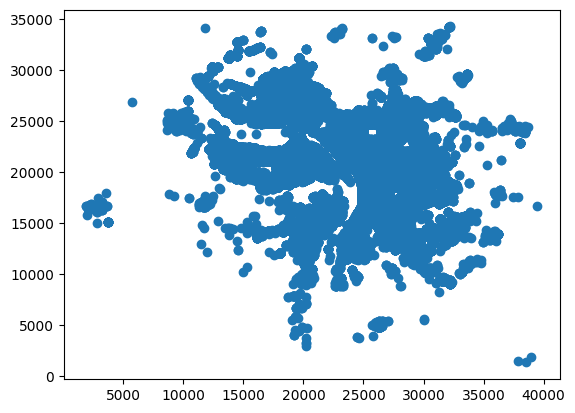

In [17]:
plt.scatter(geo_df["x_cord"], geo_df["y_cord"])

In [18]:
all_dates_of_geoset = geo_df["FORECAST_DATE"].unique()
points_array = np.array(((geo_df["x_cord"]),(geo_df["y_cord"]) ))

points_array = points_array.T

In [19]:
total_histogram = np.histogram2d(geo_df["x_cord"],geo_df["y_cord"], bins = (50,50))
total_histogram_vals = total_histogram[0]
total_histogram_bins = total_histogram[1]

total_histogram_vals = (total_histogram_vals/total_histogram_vals.sum()).T

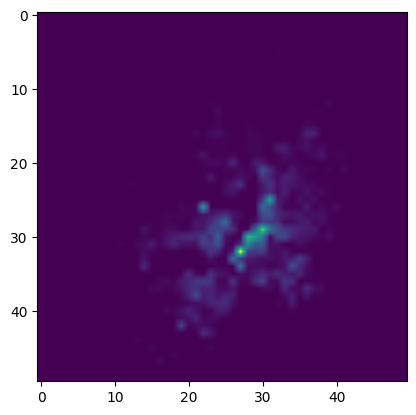

In [20]:
plt.imshow(total_histogram_vals, interpolation = "bilinear")

<Axes: >

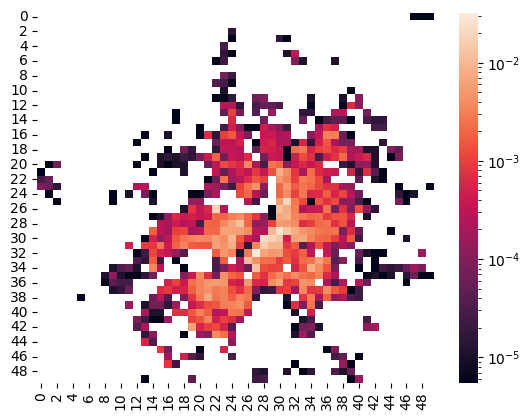

In [21]:
sns.heatmap(total_histogram_vals, norm = LogNorm())

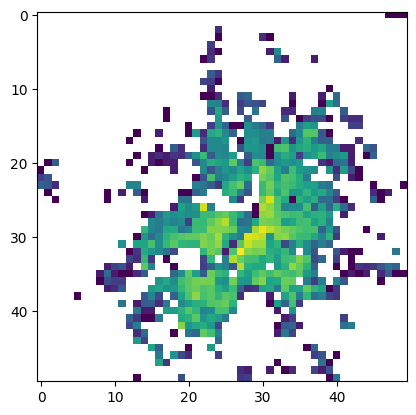

In [22]:
plt.imshow(total_histogram_vals, norm = LogNorm())

In [23]:
def heatmaps_over_day_generator(some_df):
  heatmap_tensor = []
  unique_days = list(some_df["FORECAST_DATE"].unique())
  unique_days.sort()
  tmp_histogram = np.histogram2d(geo_df[geo_df["FORECAST_DATE"] == unique_days[0]]["x_cord"],geo_df[geo_df["FORECAST_DATE"] == unique_days[0]]["y_cord"], bins = (50,50))
  tmp_histogram_vals = tmp_histogram[0]
  tmp_histogram_bins = tmp_histogram[1]
  heatmap_tensor.append(tmp_histogram_vals)
  for curr_day in unique_days:
    tmp_histogram = np.histogram2d(geo_df[geo_df["FORECAST_DATE"] == curr_day]["x_cord"],geo_df[geo_df["FORECAST_DATE"] == curr_day]["y_cord"], bins = tmp_histogram_bins)
    tmp_histogram_vals = tmp_histogram[0]
    tmp_histogram_bins = tmp_histogram[1]
    heatmap_tensor.append(tmp_histogram_vals)
  heatmap_tensor = np.array(heatmap_tensor[1::])
  return heatmap_tensor, unique_days



In [25]:
heatmap_tensor_over_days, corresponding_dates = heatmaps_over_day_generator(geo_df)

In [26]:
heatmap_tensor_over_days.shape

(600, 50, 50)

<Axes: >

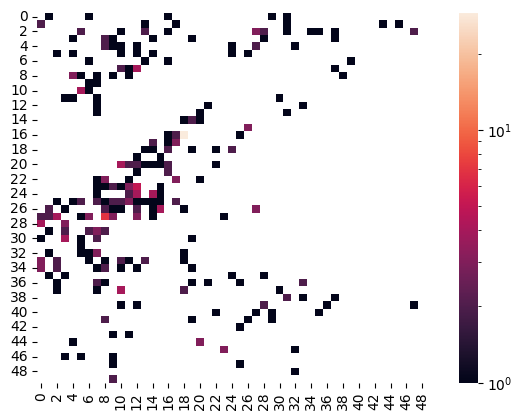

In [27]:
sns.heatmap(heatmap_tensor_over_days[532,:,:], norm = LogNorm())

In [28]:
def entropy_estimator(distribution_heatmap):
  prob_matrix = distribution_heatmap/distribution_heatmap.sum()
  entropy_matrix = np.zeros_like(prob_matrix)
  entropy_matrix[prob_matrix != 0] = prob_matrix[prob_matrix != 0]*np.log(prob_matrix[prob_matrix != 0])
  entropy = -entropy_matrix.sum()
  return entropy

In [29]:
sum_list = []
for i in range (heatmap_tensor_over_days.shape[0]):
  sum_list.append(heatmap_tensor_over_days[i,:,:].sum())

**Энтропия слабо зависит от размера выборки**

In [30]:
entropy_estimator(total_histogram_vals)

5.507587553224047

**Формируем временной ряд**

In [31]:
entropy_list = []
for i in range (heatmap_tensor_over_days.shape[0]):
  entropy_list.append(entropy_estimator(heatmap_tensor_over_days[i,:,:]))

<ipython-input-28-6026a8782893>:2: RuntimeWarning: invalid value encountered in divide
  prob_matrix = distribution_heatmap/distribution_heatmap.sum()


In [32]:
deliv_per_day = np.array(geo_df.groupby("FORECAST_DATE").count()["COMPLETED"])

In [33]:
time_series_df = geo_df.groupby(["FORECAST_DATE"]).count()


time_series_df = time_series_df[["x_cord", "y_cord"]]
time_series_df["num_of_orders"] = time_series_df["y_cord"]
time_series_df["entropy"] = entropy_list
time_series_df = time_series_df[["num_of_orders", "entropy"]]


time_series_df.to_csv("time_series_data.csv")

In [35]:
cour_data = pd.read_csv('/content/cour_per_day.csv', sep = ';')
cour_data["дата"] = cour_data["дата"].str[:10]
cour_data

,дата,Кол-во КК
0,2023-05-05,21
1,2023-05-06,10
2,2023-05-07,10
3,2023-05-08,16
4,2023-05-10,25
...,...,...
119,2023-09-02,9
120,2023-09-03,10
121,2023-09-04,22
122,2023-09-05,19


In [36]:
time_series_df

,num_of_orders,entropy
FORECAST_DATE,,
2022-01-04,22,2.201512
2022-01-05,4,1.386294
2022-01-06,17,2.197225
2022-01-08,14,1.973001
2022-01-09,18,2.145842
...,...,...
2023-08-31,567,4.985495
2023-09-01,612,5.233561
2023-09-02,198,4.318521


In [44]:
cour_data = cour_data.rename(columns = {'дата' : 'FORECAST_DATE', 'Кол-во КК' : 'cour_num'})
dates_list = list(cour_data["FORECAST_DATE"])
sub_df = time_series_df.query(' FORECAST_DATE in @dates_list ')
sub_df = sub_df.reset_index()
sub_df = sub_df.drop(["FORECAST_DATE"], axis = 1)
cour_data = cour_data.drop([122,123])

In [45]:
sub_df

,num_of_orders,entropy
0,614,5.113470
1,146,4.174179
2,169,4.276599
3,391,5.017094
4,1127,5.464009
...,...,...
117,567,4.985495
118,612,5.233561
119,198,4.318521
120,193,4.373321


**Посмотрим на нормализованные графики**

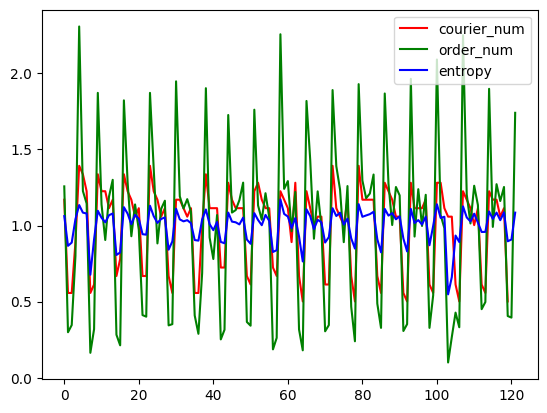

In [48]:
plt.plot(cour_data["cour_num"][:-2]/cour_data["cour_num"][:-2].mean(), color = 'red', label = "courier_num")
plt.plot(np.arange(len(sub_df)), sub_df["num_of_orders"]/sub_df["num_of_orders"].mean(), color = 'green', label = "order_num")
plt.plot(np.arange(len(sub_df)), sub_df["entropy"]/sub_df["entropy"].mean(), color = 'blue', label = "entropy")
plt.legend(loc = 'upper right')

In [49]:
sub_df["courier_num"] = cour_data["cour_num"]

In [50]:
sub_df

,num_of_orders,entropy,courier_num
0,614,5.113470,21
1,146,4.174179,10
2,169,4.276599,10
3,391,5.017094,16
4,1127,5.464009,25
...,...,...,...
117,567,4.985495,19
118,612,5.233561,20
119,198,4.318521,9
120,193,4.373321,10


In [51]:
sub_df.to_csv("dataset_for_predictions.csv")